In [88]:
import pandas as pd
import numpy as np
import networkx as nx
import math
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from sklearn.metrics import roc_auc_score, average_precision_score
## Path for dataset downloads
DATASET_PATH = "../data"
# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GAE
from torch_geometric.nn import VGAE

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# graphviz
try: 
    import pygraphviz
except ModuleNotFoundError:
  !sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
  !sudo pip install pygraphviz
from IPython.display import Image
from torch_geometric import seed_everything

cpu


In [89]:
seed_everything(42)

### Define the Encoder

In [90]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

### Define the Autoencoder

In [91]:
def train(input_edges, true_edges):
    # Set model in training mode
    model.train()
    # Set gradients to zero
    optimizer.zero_grad()
    z = model.encode(x, input_edges)
    # Binary crossentropy loss
    loss = model.recon_loss(z, true_edges)
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

def decode_all(z):
  return model.decoder.forward_all(z)


## Graph Autoencoder (Random Graphs)
> random graph encoding / decoding

> task: reconstruct original graphs from noisy data

> randomly drops edges to simulate noisy data

In [92]:
# Choose to use noisy data or original
noisyData = False
# Generates networkx graph, as well as separate labels and node features for each graph (not supported in networkx, have to be added separately to pytorch/tensorflow graph structure)
generatedGraphs = []
graph_labels = []
# maximum number of generated edges (= number of labels)
num_max_graph_nodes = 25
num_min_graph_nodes = 20
graph_node_features = []

nodes = 30
num_node_features = 5

for y in range(60):

  # set number of edges in graph
  for i in range(num_min_graph_nodes,num_max_graph_nodes+1):

    # node features dictionary with nodes as keys
    node_features_dict = {}
    node_features_arr = []
    # generate Graph: n: number of nodes, m=number of edges
    genGraph = nx.generators.random_graphs.dense_gnm_random_graph(nodes,i,seed=2)

    # set number of edges in graph as labels to learn
    graph_labels.append(i-1)

    # generate random node features
    for node in range(nodes):
      features = np.random.rand(num_node_features)
      node_features_dict[node] = features
      node_features_arr.append(features)
      
    # add node features to graph
    graph_node_features.append(node_features_arr)
    #nx.set_node_attributes(genGraph, node_features)
    generatedGraphs.append(genGraph)

    # Create Pytorch Geometric Data from generated networkx graphs and add generated node features
torch_dataset = []
for idx, graph in enumerate(generatedGraphs):
  torch_dataset.append(torch_geometric.utils.from_networkx(graph))
  # add node features to graph
  torch_dataset[idx].x = torch.tensor(graph_node_features[idx], dtype=torch.float)
  torch_dataset[idx].y = graph_labels[idx]

In [93]:
# Create Pytorch Geometric Data from generated networkx graphs and add generated node features
torch_dataset = []
for idx, graph in enumerate(generatedGraphs):
  torch_dataset.append(torch_geometric.utils.from_networkx(graph))
  # add node features to graph
  torch_dataset[idx].x = torch.tensor(graph_node_features[idx], dtype=torch.float)
  torch_dataset[idx].y = graph_labels[idx]

In [94]:
# Select single graph
data = torch_dataset[0]
# Reset train/test/val split
data.train_mask = data.val_mask = data.test_mask = None
data

Data(edge_index=[2, 40], num_nodes=30, x=[30, 5], y=19)

In [95]:
input_data = data

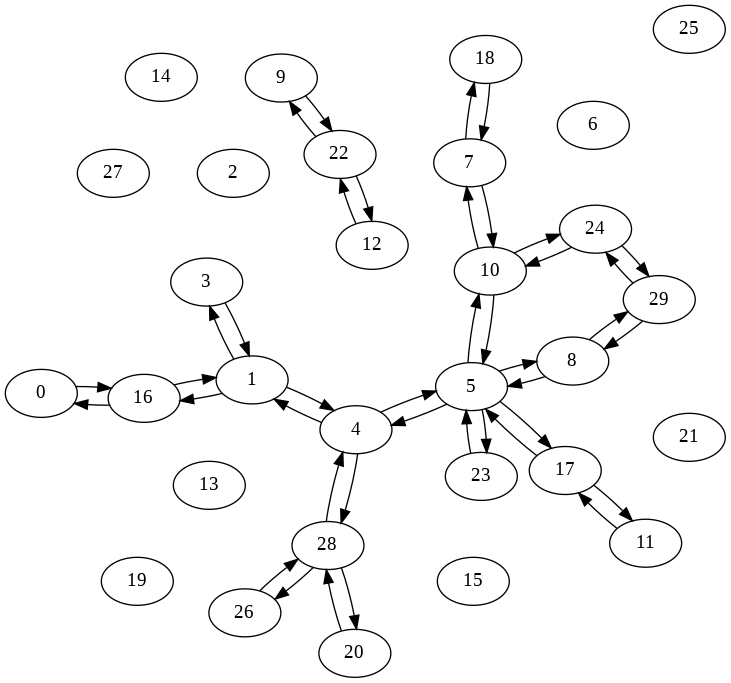

In [96]:
g = torch_geometric.utils.to_networkx(input_data, to_undirected=False)
A = nx.nx_agraph.to_agraph(g)
A.layout(prog='neato')
A.draw("graph.png")
Image('graph.png')

## Simulate noise
> randomly drop edges

In [97]:
if noisyData == True:
  corrupted_input_data = input_data.clone()
  corrupted_edges = torch_geometric.utils.dropout_adj(input_data.edge_index)
  corrupted_input_data.edge_index = corrupted_edges[0]

In [98]:
if noisyData == True:
  g = torch_geometric.utils.to_networkx(corrupted_input_data, to_undirected=False)
  A = nx.nx_agraph.to_agraph(g)
  A.layout()
  A.draw("graph.png")
  Image('graph.png')

In [99]:
# Train/Test split uncorrupted graph
# Perform negative sampling from complete graph for negative edge labels
transform = RandomLinkSplit(is_undirected=True, split_labels=True)
train_data, val_data, test_data = transform(input_data)

In [100]:
train_data

Data(edge_index=[2, 28], num_nodes=30, x=[30, 5], y=19, pos_edge_label=[14], pos_edge_label_index=[2, 14], neg_edge_label=[14], neg_edge_label_index=[2, 14])

In [101]:
if noisyData == True:
  # Train/Test split corrupted graph
  # Perform negative sampling from complete graph for negative edge labels
  transform = RandomLinkSplit(is_undirected=True, split_labels=True)
  train_data_corr, val_data_corr, test_data_corr = transform(corrupted_input_data)
  train_data_corr

## Create Model

In [102]:
# parameters
out_channels = 2
num_features = num_node_features
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))
x=train_data.x
pos_edge_index_true = train_data.edge_index
if noisyData == True:
  pos_edge_index_corr = train_data_corr.edge_index


# initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [103]:
print(pos_edge_index_true)

tensor([[ 1, 10, 24, 11,  1,  7,  0,  4,  5,  7,  5,  1,  5, 20,  4, 24, 29, 17,
          3, 10, 16,  5,  8, 18, 17, 16, 10, 28],
        [ 4, 24, 29, 17,  3, 10, 16,  5,  8, 18, 17, 16, 10, 28,  1, 10, 24, 11,
          1,  7,  0,  4,  5,  7,  5,  1,  5, 20]])


In [104]:
if noisyData == True:
  print(pos_edge_index_corr)

In [105]:
# Train
for epoch in range(1, epochs + 1):
    if noisyData == True:
      loss = train(pos_edge_index_corr, pos_edge_index_true)
    else:
      loss = train(pos_edge_index_true, pos_edge_index_true)

    #auc, ap = test(test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    #print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    print(loss)

1.3900166749954224
1.389282464981079
1.3862543106079102
1.3781466484069824
1.3775582313537598
1.3753174543380737
1.3770427703857422
1.3676202297210693
1.3691060543060303
1.3588299751281738
1.3610174655914307
1.3592294454574585
1.3355399370193481
1.344773769378662
1.3471860885620117
1.3430590629577637
1.3402090072631836
1.3424029350280762
1.348479986190796
1.3139393329620361
1.3042352199554443
1.3402323722839355
1.2872368097305298
1.3023632764816284
1.3288722038269043
1.3071584701538086
1.313715934753418
1.3027188777923584
1.3322031497955322
1.3264966011047363
1.2660356760025024
1.2610833644866943
1.3075814247131348
1.2277069091796875
1.243335485458374
1.2597355842590332
1.2776179313659668
1.2693039178848267
1.308340072631836
1.2288298606872559
1.287646770477295
1.2806131839752197
1.2800319194793701
1.295229196548462
1.2756688594818115
1.2737843990325928
1.274700403213501
1.2285497188568115
1.2079840898513794
1.3040297031402588
1.2480448484420776
1.2362210750579834
1.3014516830444336
1.

In [106]:
Z = model.encode(x, input_data.edge_index)
print(Z.size())

torch.Size([30, 2])


## Decode latent representation

In [107]:
# Decode latent representation
# Predicts edges likelihood for given edge index list
# Reconstruct all positive edges
predicted_pos_edges = model.decode(Z,input_data.edge_index)
predicted_pos_edges

tensor([0.6740, 0.4923, 0.5296, 0.5498, 0.4923, 0.5296, 0.6661, 0.4956, 0.6661,
        0.8116, 0.8561, 0.8371, 0.8401, 0.7297, 0.6064, 0.8116, 0.7075, 0.5676,
        0.8561, 0.7297, 0.7720, 0.7258, 0.5272, 0.6740, 0.5498, 0.8371, 0.7258,
        0.6064, 0.5077, 0.5676, 0.5272, 0.8401, 0.7720, 0.7100, 0.5082, 0.4956,
        0.5077, 0.5082, 0.7075, 0.7100], grad_fn=<SigmoidBackward0>)

In [108]:
# Convert to binary values [True,False]
predicted_pos_edges = np.where(predicted_pos_edges > 0.5, True, False)


## Create edge indices from predictions

In [109]:
# Select all start nodes where predicted_pos_edges = True
pred_from = np.array(data.edge_index[0][predicted_pos_edges])
# Select all end nodes where predicted_pos_edges = True
pred_to = np.array(data.edge_index[1][predicted_pos_edges])

# Create new edge index for predicted graph
predicted_pos_edge_index = np.array([pred_from, pred_to])
print(predicted_pos_edge_index)

# Set new edge index in graph
predicted_graph = data
predicted_graph.edge_index =  torch.from_numpy(predicted_pos_edge_index)


[[ 0  1  1  4  4  5  5  5  5  5  7  7  8  8  9 10 10 10 11 12 16 16 17 17
  18 20 22 22 23 24 24 26 28 28 29 29]
 [16  4 16  1  5  4  8 10 17 23 10 18  5 29 22  5  7 24 17 22  0  1  5 11
   7 28  9 12  5 10 29 28 20 26  8 24]]


## Draw predicted graph

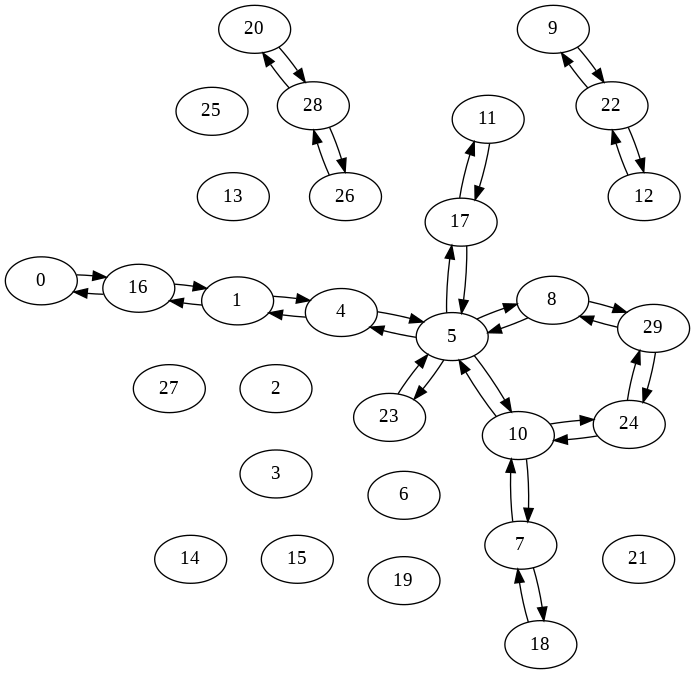

In [110]:
g = torch_geometric.utils.to_networkx(predicted_graph, to_undirected=False)
A = nx.nx_agraph.to_agraph(g)
A.layout()
A.draw("graph.png")
Image('graph.png')

## Variational Autoencoder


In [111]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [112]:
model = VGAE(VariationalGCNEncoder(num_features, out_channels))

In [113]:
def train(input_edges, true_edges):
    # Set model in training mode
    model.train()
    # Set gradients to zero
    optimizer.zero_grad()
    z = model.encode(x, input_edges)
    loss = model.recon_loss(z, true_edges)
    # Binary crossentropy loss
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

def decode_all(z):
  return model.decoder.forward_all(z)

In [114]:
for epoch in range(1, epochs + 1):
    if noisyData == True:
      loss = train(pos_edge_index_corr, pos_edge_index_true)
    else:
      loss = train(pos_edge_index_true, pos_edge_index_true)


In [115]:
# Encode graph to latent mu /standard deviation pairs
latent = model.encode(x, input_data.edge_index)

In [116]:
# Sample Z from latent representation
Z = model.reparametrize(model.__mu__, model.__logstd__)
# Decode Z
predicted_pos_edges = model.decode(Z,input_data.edge_index)

In [117]:
# Convert to binary values [True,False]
predicted_pos_edges = np.where(predicted_pos_edges > 0.5, True, False)

In [118]:
# Select all start nodes where predicted_pos_edges = True
pred_from = np.array(data.edge_index[0][predicted_pos_edges])
# Select all end nodes where predicted_pos_edges = True
pred_to = np.array(data.edge_index[1][predicted_pos_edges])

# Create new edge index for predicted graph
predicted_pos_edge_index = np.array([pred_from, pred_to])
print(predicted_pos_edge_index)

# Set new edge index in graph
predicted_graph = data
predicted_graph.edge_index =  torch.from_numpy(predicted_pos_edge_index)

[[ 1  4  5  5  7  8 10 12 16 17 18 22 24 24 29 29]
 [16  5  4 17 18 29 24 22  1  5  7 12 10 29  8 24]]


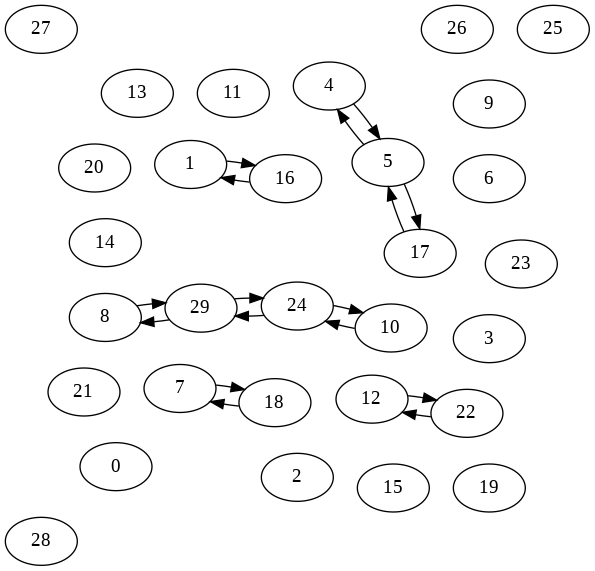

In [119]:
g = torch_geometric.utils.to_networkx(predicted_graph, to_undirected=False)
A = nx.nx_agraph.to_agraph(g)
A.layout()
A.draw("graph.png")
Image('graph.png')